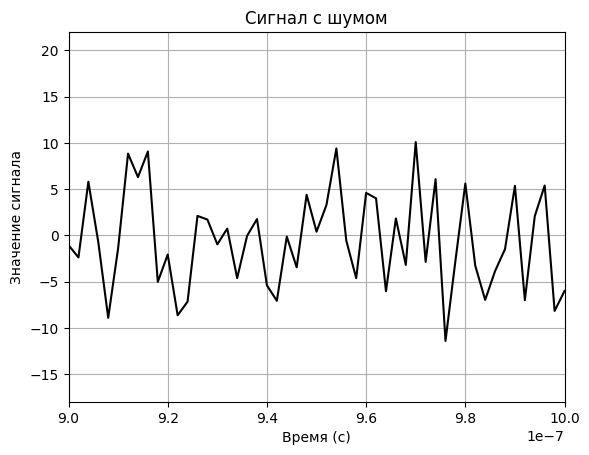

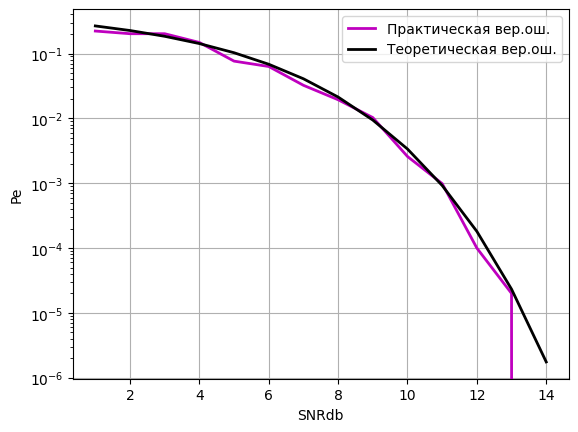

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.special import comb, erfc  

np.random.seed(42) 

q = 2  
T = 5e-6  # Период сигнала (2 * 10^-6)
f0 = 10e6  # Частота основного сигнала (20 * 10^6)
dtf = 1 / T  
Ns = 50  
A = 1 
dt = 1 / (Ns * f0)  
t = np.arange(0, T, dt)  

f = np.zeros(q)  
s = np.zeros((q, len(t)))  
f1 = np.zeros((q, len(t)))  #Массив для частотных составляющих (косинус)
f2 = np.zeros((q, len(t)))  #Массив для частотных составляющих (синус)

#Генерация сигналов
for i in range(q):
    f[i] = f0 + (i - 1) * dtf
    s[i, :] = A * np.cos(2 * np.pi * f[i] * t)  #Генерация квадратурного сигнала
    f1[i, :] = np.sqrt(2 / T) * np.cos(2 * np.pi * f[i] * t)  #Частотная составляющая (косинус)
    f2[i, :] = np.sqrt(2 / T) * np.sin(2 * np.pi * f[i] * t)  #Частотная составляющая (синус)

E = np.linalg.norm(s[0, :]) ** 2  
#--------------------------------------
Nerrmax = 20 
num_tests = 50000 
SNRdb = np.arange(1, 15)  
Pe = np.zeros(len(SNRdb))  #практическая вер. ошибки (массив)
Pe_teor = np.zeros(len(SNRdb))  #теоретическая вер. ошибки (массив)

r = np.zeros_like(t)  #Массив принятых сигналов
ni = np.zeros(q)  

#Цикл по значениям отношения сигнал-шум (SNRdb)
for ns in range(len(SNRdb)):
    SNR = 10 ** (SNRdb[ns] / 10) 
    N0 = E / SNR  #Среднеквадратичное значение шума
    sigma = np.sqrt(N0 / 2)  #Стандартное отклонение шума
    Nerr = 0  
    Ntest = 0  
    Pe_t = 0  

    #Вычисление теоретической вероятности ошибки
    for l in range(1, q):
        Pe_t += comb(q - 1, l) * (-1) ** (l + 1) * 1 / (1 + l) * np.exp(-l / (l + 1) * E / N0)

    last_test = Ntest  

    #Тестирование приема сигнала с шумом
    while Nerr < Nerrmax:
        i = np.random.randint(0, q)  #случайный индекс сигнала
        r = np.cos(2 * np.pi * f[i] * t + 2 * np.pi * np.random.rand()) + sigma * np.random.randn(len(t))  

        for j in range(q):
            rci = np.dot(r, f1[j, :])
            rsi = np.dot(r, f2[j, :])
            ni[j] = rci ** 2 + rsi ** 2 #принятие решения

        index_max = np.argmax(ni)  
        if index_max != i:
            Nerr += 1  #Ошибка приема сигнала
        Ntest += 1  
#Прекращение тестирования, если выполнено необходимое количество тестов
        if Ntest - last_test > num_tests:
            break  

    Pe[ns] = Nerr / Ntest  #практическая вероятность ошибки
    Pe_teor[ns] = Pe_t  #теоретическая вероятность ошибки

plt.figure(1)
plt.plot(t, r, 'k')  
plt.title('Сигнал с шумом') 
plt.xlabel('Время (с)')  
plt.ylabel('Значение сигнала')  
plt.xlim([0.9 * 10**-6, 1 * 10**-6]) 
plt.grid(True)  

plt.figure(2)
plt.semilogy(SNRdb, Pe, 'm', SNRdb, Pe_teor, "k", linewidth=2)
plt.xlabel('SNRdb')  
plt.ylabel('Pe')  
plt.legend(['Практическая вер.ош.', 'Теоретическая вер.ош.'])  
plt.grid(True) 

plt.show()  
